# BSc Thesis: Evaluation of Decision Tree and Random Forest Classifiers in the Finance Domain

## Table of Contents
0. Preparation
1. Data Preparation Stage
2. Feature Extraction
3. Classification
4. Evaluation of Models
5. Visualisations

# 0 | Preparation

### Jupyter Shortcuts
- A -> Insert cell above
- B -> Insert cell below
- M -> Markdown cell
- Y -> Code cell
- DD -> Delete cell
- Z -> undo action
- Esc: enter command mode


- Ctrl-M: enter command mode
- Tab: code completion or indent
- Shift-Tab: tooltip for objects and functions
- Shift-Enter: run cell, select below
- Ctrl-Enter: run selected cells
- Alt-Enter: run cell and insert below
- Ctrl-#: (De-)comment

### Imports

In [92]:
# Data manipulation and arrays
import pandas as pd
import numpy as np

# Machine learning library
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn import metrics

# Plottig
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

# Define filenames for .CSV datasets
microsoft = "Datasets/Kaggle_SnP500_MSFT_2013-2018.csv"
google = "Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv"
apple = "Datasets/Kaggle_SnP500_AAPL_2013-2018.csv"
# TBD: Const Veriablen UPPER CASE!

# 1 | Data Preparation Stage
- Load data, adjust columns as needed and extract features
- No feature selection needed as embedded in DT and RF

## 1.1. | Load Datasets
- For an apples-to-apples comparison technology companies are analyzed
- Selected stocks differ in price trends: upward vs mean vs downward trend

In [93]:
def load_OHLC_data(filename="Datasets/Kaggle_SnP500_MSFT_2013-2018.csv"):
    """
    Loads basic stock data (date, name, open, high, low, close) from a given .CSV file and returns DataFrame.
    Not needed categorical columns are dropped, and necessary columns (e.g. classification target) are added.
    """
    try:
        df = pd.read_csv(filename)
        
        # Drop not needed categorical columns
        df = df.drop(columns=["Name"])
        # Convert date to month to possibly detect cyclicality (e.g. christmas effect) in time series
        df["month"] = df["date"].astype("datetime64[ns]").dt.month
        
        # Create basis for classification target variable. Trading strategy: Buy at end of today, sell at end of tomorrow
        df["return_in_1d"] = df["close"].shift(-1)/df["close"]-1
        # df["return_in_3d"] = df["close"].shift(-3)/df["close"]-1
        # df["return_in_5d"] = df["close"].shift(-5)/df["close"]-1
        # df["return_in_10d"] = df["close"].shift(-10)/df["close"]-1
        # df["return_in_20d"] = df["close"].shift(-20)/df["close"]-1
        
        # print("Loaded DataFrame has the following columns:")
        # for col in df:
        #     print("Column \'" + col + "\' with type", type(df[col][0]), ", e.g.", df[col][0])
        # print("df.head():")
        # print(df.head())
        
        # # Visualize loaded time series data
        # df["ohlc_avg"] = df[["open", "high", "low", "close"]].mean(axis=1)
        # df.plot(x='date', y='ohlc_avg', figsize=(12,6), legend=None)
        # plt.xlabel('Date')
        # plt.ylabel('Price (Daily OHLC-Average in USD)')
        # plt.title('Microsoft Stock Data 2013 to 2018');
        # plt.savefig("./plots/DataPreparation_MSFT-Stock-Price-Plot.jpeg")
        
        return df
    except:
        print("Sorry, failed to find or load OHLC data from file with name \'"
              + filename + "\'. Please provide well-formed CSV file with stock data")


df_MSFT = load_OHLC_data(microsoft)
# df_AAPL = load_OHLC_data("Kaggle_SnP500_AAPL_2013-2018.csv")
# df_GOOGL = load_OHLC_data("Kaggle_SnP500_GOOGL_2013-2018.csv")

## 1.2 | Extract Features
- Common metrics for technical analysis are calculated
- Source: TBD

In [94]:
def extract_OHLC_features(df):
    """
    Extract common technical stock analysis features from given OHLC-DataFrame
    """
    # Daily/weekly/monthly return
    df["daily_return"] = df["close"] / df["open"] -1
    
    # OHLC average is used for daily stock price average
    df["ohlc_avg"] = df[["open", "high", "low", "close"]].mean(axis=1)
    
    # Implied volatility (standard std formula with ddof=1)
    df["volatility_3d"] = df["close"].rolling(3).std()
    df["volatility_5d"] = df["close"].rolling(5).std()
    df["volatility_10d"] = df["close"].rolling(10).std()
    df["volatility_20d"] = df["close"].rolling(20).std()
    df["volatility_50d"] = df["close"].rolling(50).std()
    df["volatility_100d"] = df["close"].rolling(20).std()

    # Percent changes past
    df["pct_change_1"] = df["close"].pct_change(1)
    df["pct_change_3"] = df["close"].pct_change(3)
    df["pct_change_5"] = df["close"].pct_change(5)
    df["pct_change_10"] = df["close"].pct_change(10)

    # Moving averages
    df["ma_3"] = df["close"].rolling(3).mean()
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_10"] = df["close"].rolling(10).mean()
    df["ma_20"] = df["close"].rolling(20).mean()
    df["ma_50"] = df["close"].rolling(50).mean()
    df["ma_100"] = df["close"].rolling(100).mean()
    
    # Replace NaNs with 0's ()
    df = df.fillna(value=0)
    return df


df_MSFT = extract_OHLC_features(df_MSFT)
print(df_MSFT.head())
# Add other df's

         date   open   high    low  close    volume  month  return_in_1d  \
0  2013-02-08  27.35  27.71  27.31  27.55  33318306      2      0.011252   
1  2013-02-11  27.65  27.92  27.50  27.86  32247549      2      0.000718   
2  2013-02-12  27.88  28.00  27.75  27.88  35990829      2      0.005380   
3  2013-02-13  27.93  28.11  27.88  28.03  41715530      2      0.000357   
4  2013-02-14  27.92  28.06  27.87  28.04  32663174      2     -0.001070   

   daily_return  ohlc_avg   ...    pct_change_1  pct_change_3  pct_change_5  \
0      0.007313   27.4800   ...        0.000000      0.000000           0.0   
1      0.007595   27.7325   ...        0.011252      0.000000           0.0   
2      0.000000   27.8775   ...        0.000718      0.000000           0.0   
3      0.003580   27.9875   ...        0.005380      0.017423           0.0   
4      0.004298   27.9725   ...        0.000357      0.006461           0.0   

   pct_change_10       ma_3    ma_5  ma_10  ma_20  ma_50  ma_100  
0

## 1.3 | Anomaly Detection (any obvious outliers in stock data? if so, explain)
Days with abs(percent_change_to_next_day) > 5% are considered outliers. They occur in less than TBD% of instances.

Ergebnis: 7 Tage mit Tages-Rendite > 5%, TBD: Zeitungsartikel

In [95]:
def detect_anomalies(df):
    """
    Iterates through the DataFrame and prints out all dates where 1-day-return is greater than 5%.
    """
    for i in range(len(df)):
        x = df["return_in_1d"][i]
        d = df["date"][i]
        if (x > 0.05):
            print("Anomaly: Daily return of " + str(round(x * 100, 2)) + "% on " + d)


detect_anomalies(df_MSFT)
# Add other df's

Anomaly: Daily return of 7.29% on 2013-08-22
Anomaly: Daily return of 5.96% on 2013-10-24
Anomaly: Daily return of 10.45% on 2015-04-23
Anomaly: Daily return of 5.53% on 2015-08-25
Anomaly: Daily return of 10.08% on 2015-10-22
Anomaly: Daily return of 5.83% on 2016-01-28
Anomaly: Daily return of 5.31% on 2016-07-19
Anomaly: Daily return of 6.41% on 2017-10-26


## 1.4 | Define Classes: Should an investor buy a given stock and sell it in 5d? Yes/No

In [96]:
def define_target(df):
    """
    Create target column in df: 1 means 'Yes, investor should buy stock', 0 means 'No, investor should not buy stock'.
    The assumed trading strategy here is, that the investor sells the stock at the end of next day.
    Also removes illegal columns (e.g. future data) and raplaces NaN values with 0.
    """
    if "target" not in df.columns:
        df["target"] = np.where(df["return_in_1d"] > 0, 1, 0)
        df = df.drop(columns=["date", "return_in_1d"])
        df = df.fillna(value=0)
    return df


df_MSFT = define_target(df_MSFT)
print(df_MSFT.head())
# Add other df's

    open   high    low  close    volume  month  daily_return  ohlc_avg  \
0  27.35  27.71  27.31  27.55  33318306      2      0.007313   27.4800   
1  27.65  27.92  27.50  27.86  32247549      2      0.007595   27.7325   
2  27.88  28.00  27.75  27.88  35990829      2      0.000000   27.8775   
3  27.93  28.11  27.88  28.03  41715530      2      0.003580   27.9875   
4  27.92  28.06  27.87  28.04  32663174      2      0.004298   27.9725   

   volatility_3d  volatility_5d   ...    pct_change_3  pct_change_5  \
0       0.000000       0.000000   ...        0.000000           0.0   
1       0.000000       0.000000   ...        0.000000           0.0   
2       0.185023       0.000000   ...        0.000000           0.0   
3       0.092916       0.000000   ...        0.017423           0.0   
4       0.089629       0.198167   ...        0.006461           0.0   

   pct_change_10       ma_3    ma_5  ma_10  ma_20  ma_50  ma_100  target  
0            0.0   0.000000   0.000    0.0    0.0    

## 1.5 | Check class balance
- The two classes should be balanced

1    655
0    604
Name: target, dtype: int64

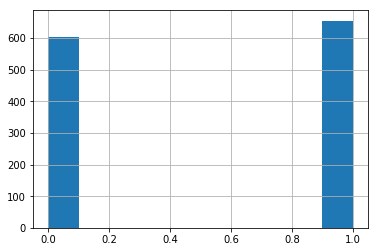

In [97]:
df_MSFT["target"].hist()

df_MSFT["target"].value_counts()

# proportion_class_0 = df_MSFT["target"].groupby(0).count() / len(df_MSFT["target"])
# proportion_class_1 = df_MSFT["target"].groupby(1).count() / len(df_MSFT["target"])
# print("Distribution of classes: D<class=0, class=0> = <", proportion_class_0,", ", proportion_class_1, ">")

## 1.6.1 | TEST: Seaborn plot correlations with target

Ergebnis: volatility-volume stark pos. korreliert (0.45), ohlc_avg-volume mäßig neg. korreliert (-0.36)

<Figure size 432x288 with 0 Axes>

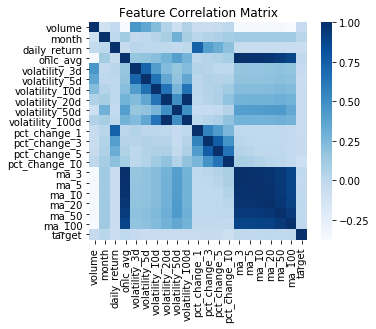

<Figure size 432x288 with 0 Axes>

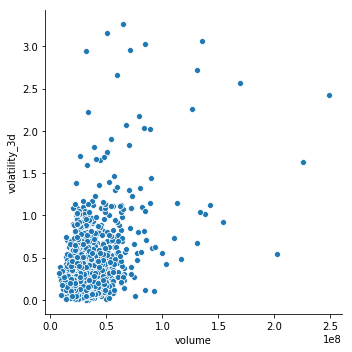

<Figure size 432x288 with 0 Axes>

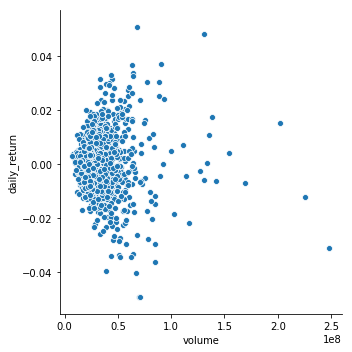

<Figure size 432x288 with 0 Axes>

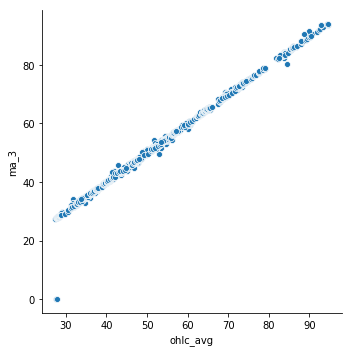

In [98]:
def plot_corr_sns(df):
    df = df.drop(columns=["open", "high", "low", "close"])
    corr = df.corr()
    
    plt.figure()
    f, ax = plt.subplots(figsize=(5, 4)) #PARAM: figsize=(15, 12)
    ax.set_title("Feature Correlation Matrix")
    sns.heatmap(corr, cmap=plt.cm.Blues, mask=np.zeros_like(corr, dtype=np.bool), square=True, ax=ax)
    # plt.savefig("./plots/DataPreparation_MSFT-Stock-Data_correlation-matrix_v4.jpeg")
    
    plt.figure()
    sns.relplot(x="volume", y="volatility_3d", data=df);
    
    plt.figure()
    sns.relplot(x="volume", y="daily_return", data=df);
    
    plt.figure()
    sns.relplot(x="ohlc_avg", y="ma_3", data=df);


plot_corr_sns(df_MSFT)
# Add other df's

In [ ]:
tbc